<a href="https://colab.research.google.com/github/SUDIPA9002/SKIN-Cancer-detection-using-CNN/blob/main/Skin_Cancer_Detection_model_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np

import cv2
import os
from random import shuffle
from tqdm import tqdm
import random

#for opening and loading image
from PIL import Image

#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle

#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

### Mounting Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls drive

MyDrive  Shareddrives


### Loading Images in Directory

In [ ]:
# setting path of directory
Benign_DIR = "/content/drive/My Drive/skin_cancer_dataset/Benign/train/"
Malignant_DIR =  "/content/drive/My Drive/skin_cancer_dataset/Malignant/train/"


# storing all the files from directories PARA_DIR and NORM_DIR to Bimages and Mimages for accessing images directly
Bimages = os.listdir(Benign_DIR)
Mimages = os.listdir(Malignant_DIR)


### Checking sample images

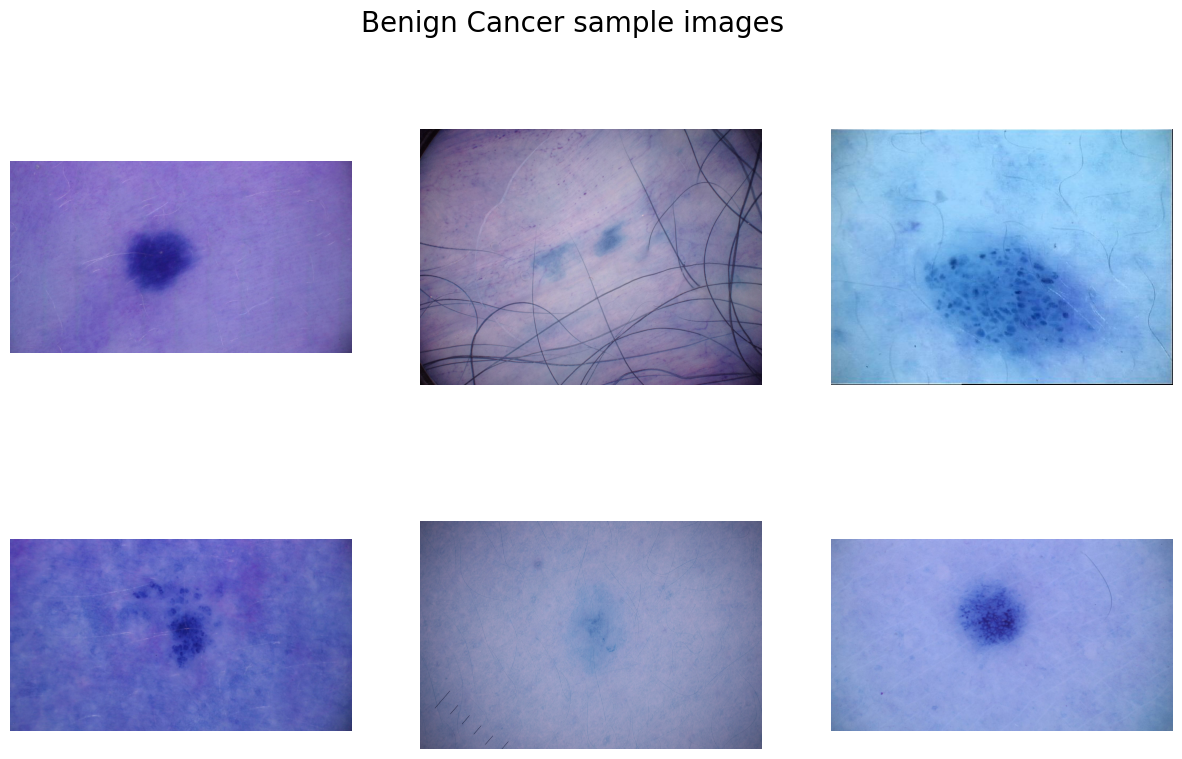

In [ ]:
sample_parasite = random.sample(Bimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Benign/train/" +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Benign Cancer sample images',fontsize=20)
plt.show()

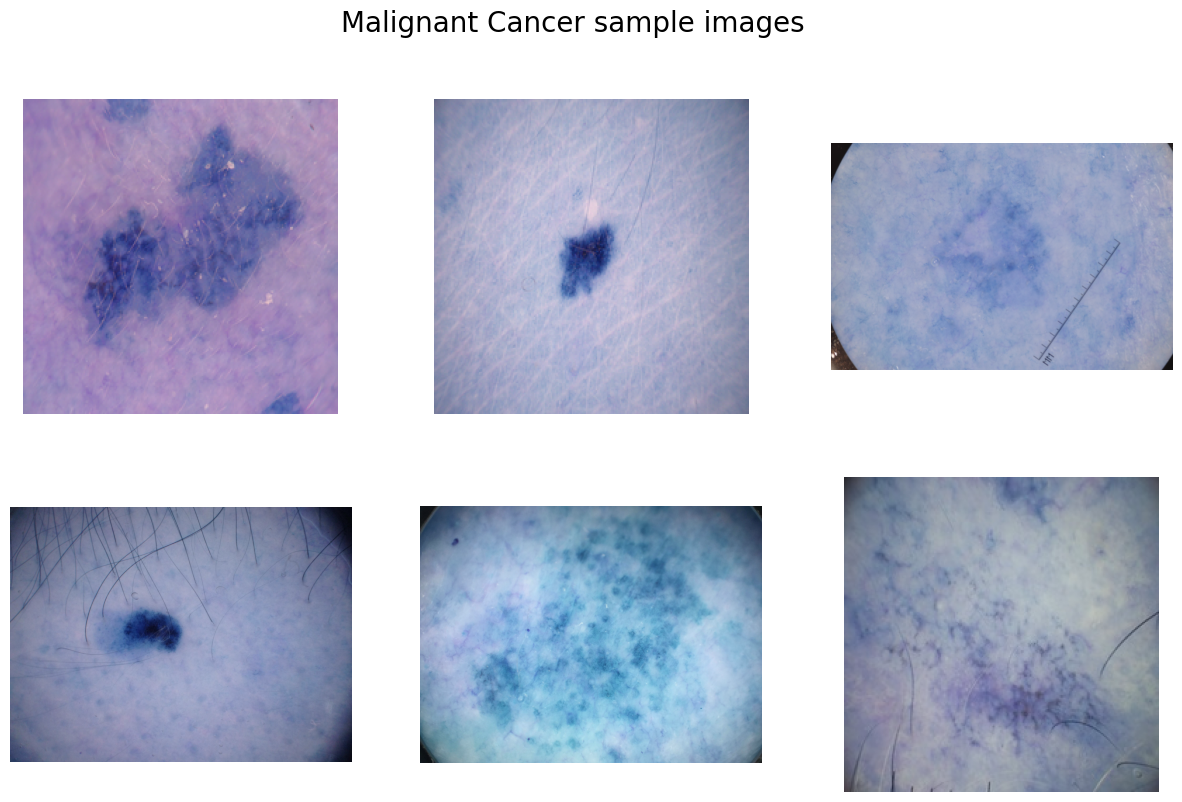

In [ ]:
sample_parasite = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(Malignant_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Malignant Cancer sample images',fontsize=20)
plt.show()

## Data Preparation - Loading Images and Labels

In [ ]:
data=[]
labels=[]
Benign=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Benign/train/")
for a in Benign:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Benign/train/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Malignant=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Malignant/train/")
for b in Malignant:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Malignant/train/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/My Drive/skin_cancer_dataset/feats2_train",feats)
np.save("/content/drive/My Drive/skin_cancer_dataset/labels2_train",labels)

## Loading saved data and labels

In [ ]:
feats=np.load("/content/drive/My Drive/skin_cancer_dataset/feats2_train.npy")
labels=np.load("/content/drive/My Drive/skin_cancer_dataset/labels2_train.npy")

## Randomizing Data and Labels

In [ ]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

3997


In [ ]:
print(num_classes)

2


## Train Test Split

In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

## Image Data Normalization

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
y_train=to_categorical(y_train,2)
y_test=to_categorical(y_test,2)

## Image Augmentation

In [ ]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

## Model Building

In [ ]:
### Model Building using VGG16
from tensorflow.keras.applications import VGG16

# Load the VGG16 model with weights pre-trained on ImageNet
conv_base_vgg16 = VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

for layer in conv_base_vgg16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
x = conv_base_vgg16.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions_vgg16 = layers.Dense(2, activation='softmax')(x)

model_vgg16 = Model(conv_base_vgg16.input, predictions_vgg16)

model_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Training the model
callbacks_vgg16 = [ModelCheckpoint('.mdl_wts_vgg16.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]


In [ ]:
BS = 64
print("[INFO] training head using VGG16...")
H_vgg16 = model_vgg16.fit(
    trainAug.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=30,
    callbacks=callbacks_vgg16
)

[INFO] training head using VGG16...
Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8293 
Epoch 1: val_loss did not improve from 0.41266
49/49 [==============================] - 1179s 24s/step - loss: 0.3866 - accuracy: 0.8293 - val_loss: 0.4273 - val_accuracy: 0.7960 - lr: 9.0000e-05
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8255 
Epoch 2: val_loss did not improve from 0.41266
49/49 [==============================] - 1147s 23s/step - loss: 0.3888 - accuracy: 0.8255 - val_loss: 0.4188 - val_accuracy: 0.8023 - lr: 9.0000e-05
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8255 
Epoch 3: val_loss did not improve from 0.41266
49/49 [==============================] - 1149s 24s/step - loss: 0.3896 - accuracy: 0.8255 - val_loss: 0.4202 - val_accuracy: 0.7997 - lr: 9.0000e-05
Epoch 4/30
 5/49 [==>...........................] - ETA: 13:45 - loss: 0.3696 - accuracy: 0

## Saving and Loading Model

In [ ]:
model_vgg16 = load_model('.mdl_wts_vgg16.hdf5')
model_vgg16.save('/content/drive/My Drive/skin_model/predicted_model_vgg16.h5')


In [ ]:
model_vgg16 = load_model('/content/drive/My Drive/skin_model/predicted_model_vgg16.h5')
# checking the accuracy
accuracy_vgg16 = model_vgg16.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy using VGG16:-', accuracy_vgg16[1])


In [ ]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]

In [ ]:
# Plotting confusion matrix for VGG16 model
y_pred_vgg16 = model_vgg16.predict(x_test, batch_size=BS)
Y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)
rounded_labels_vgg16 = np.argmax(y_test, axis=1)
confusion_mtx_vgg16 = confusion_matrix(rounded_labels_vgg16, Y_pred_classes_vgg16)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_vgg16, classes=range(2))

In [ ]:
# Convert predictions and labels to class names
class_names = ['Benign', 'Malignant']
pred_class_names = [class_names[i] for i in Y_pred_classes_vgg16]
true_class_names = [class_names[i] for i in rounded_labels_vgg16]

# Show a nicely formatted classification report
print(classification_report(rounded_labels_vgg16, Y_pred_classes_vgg16, target_names=class_names))

In [ ]:
# Calculate and print accuracy for VGG16 model
accu1_vgg16 = accuracy_score(rounded_labels_vgg16, Y_pred_classes_vgg16, normalize=False)
print("Accuracy using VGG16:", accu1_vgg16)


# Plotting ROC AUC

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Plot ROC AUC for VGG16 model
y_test_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 2

pred_Y_vgg16 = model_vgg16.predict(x_test, batch_size=BS)
fpr_vgg16 = dict()
tpr_vgg16 = dict()
roc_auc_vgg16 = dict()
for i in range(n_classes):
    fpr_vgg16[i], tpr_vgg16[i], _ = roc_curve(y_test_bin[:, i], pred_Y_vgg16[:, i])
    roc_auc_vgg16[i] = auc(fpr_vgg16[i], tpr_vgg16[i])

# Plot ROC curves
plt.figure()
plt.plot(fpr_vgg16[1], tpr_vgg16[1], label='ROC curve (area = %0.2f)' % roc_auc_vgg16[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for VGG16 model')
plt.legend(loc="lower right")
plt.show()

# Calculate macro-average and micro-average ROC AUC for VGG16 model
fpr_vgg16["macro"] = np.unique(np.concatenate([fpr_vgg16[i] for i in range(n_classes)]))
tpr_vgg16["macro"] = np.mean([tpr_vgg16[i] for i in range(n_classes)], axis=0)
roc_auc_vgg16["macro"] = auc(fpr_vgg16["macro"], tpr_vgg16["macro"])

fpr_vgg16["micro"], tpr_vgg16["micro"], _ = roc_curve(y_test_bin.ravel(), pred_Y_vgg16.ravel())
roc_auc_vgg16["micro"] = auc(fpr_vgg16["micro"], tpr_vgg16["micro"])

# Plot macro and micro ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_vgg16["micro"], tpr_vgg16["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_vgg16["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_vgg16["macro"], tpr_vgg16["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_vgg16["macro"]), color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_vgg16[i], tpr_vgg16[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_vgg16[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic for VGG16 model')
plt.legend(loc="lower right")
plt.show()


## Preparing Test Data

In [ ]:
## Preparing Test Data for VGG16 model
data_vgg16 = []
labels_vgg16 = []
Benign_vgg16 = os.listdir("/content/drive/My Drive/skin_cancer_dataset/Benign/test/")
for a in Benign_vgg16:
    try:
        image_vgg16 = cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Benign/test/" + a)
        image_from_array_vgg16 = Image.fromarray(image_vgg16, 'RGB')
        size_image_vgg16 = image_from in the new model
        size_image_vgg16 = image_from_array_vgg16.resize((224, 224))
        data_vgg16.append(np.array(size_image_vgg16))
        labels_vgg16.append(0)
    except AttributeError:
        print(a)

Malignant_vgg16 = os.listdir("/content/drive/My Drive/skin_cancer_dataset/Malignant/test/")
for b in Malignant_vgg16:
    try:
        image_vgg16 = cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Malignant/test/" + b)
        image_from_array_vgg16 = Image.fromarray(image_vgg16, 'RGB')
        size_image_vgg16 = image_from_array_vgg16.resize((224, 224))
        data_vgg16.append(np.array(size_image_vgg16))
        labels_vgg16.append(1)
    except AttributeError:
        print(b)

test_x_vgg16 = np.array(data_vgg16)
test_y_vgg16 = np.array(labels_vgg16)

# Normalize the test data
test_x_vgg16 = test_x_vgg16.astype('float32') / 255.0

# Convert test labels to one-hot encoding
test_y_vgg16 = to_categorical(test_y_vgg16, num_classes=2)

# Evaluate the VGG16 model on the test data
accuracy_test_vgg16 = model_vgg16.evaluate(test_x_vgg16, test_y_vgg16, verbose=1)
print('\n', 'Test Accuracy for VGG16 model:', accuracy_test_vgg16[1])


In [ ]:
feats_test=np.array(data)
labels_test=np.array(labels)

np.save("/content/drive/My Drive/skin_cancer_dataset/feats_test",feats_test)
np.save("/content/drive/My Drive/skin_cancer_dataset/labels_test",labels_test)

In [ ]:
feats_test=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_test.npy")
labels_test=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

In [ ]:
x_valid = feats_test.astype('float32')/255
y_valid=to_categorical(labels_test,2)

In [ ]:
# Predict the values from the test dataset
y_pred_vgg16 = model_vgg16.predict(test_x_vgg16, batch_size=16, verbose=0)
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)
true_classes_vgg16 = np.argmax(test_y_vgg16, axis=1)

# Compute the confusion matrix
confusion_mtx_vgg16 = confusion_matrix(true_classes_vgg16, y_pred_classes_vgg16)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx_vgg16, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VGG16 Model on Test Data')
plt.show()

In [ ]:
model = load_model('/content/drive/My Drive/skin_model/predicted_model1.h5')

In [ ]:
img1 = "/content/drive/MyDrive/skin_cancer_dataset/Malignant/test/malignant_ISIC_0149568.jpg"
img2 ="/content/drive/MyDrive/skin_cancer_dataset/Benign/test/benign_ISIC_0513392.jpg"
img3 ="/content/drive/MyDrive/skin_cancer_dataset/Benign/test/benign_ISIC_0558046.jpg"

In [ ]:
class_dict ={0:"Benign (Non-Cancerous)",
             1:"Malignant (Cancer)"}

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )

  return prediction

In [ ]:
from IPython.display import  display
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255

  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  # pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]
  if pred[0] in class_dict:
        pred_cat = class_dict[pred[0]]
  else:
        pred_cat = "Unknown Class"

  return pred_cat


In [ ]:
pred_image(img1,model)

In [ ]:
pred_image(img2,model)

In [ ]:
pred_image(img3,model)

# Plotting Sample Predictions

In [ ]:

y_hat = model.predict(x_test)

# define text labels
skin_labels = ['Benign','Malignant']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [ ]:
!pip install tf-keras-vis

In [ ]:
from tensorflow.keras.preprocessing import image
img_path='/content/drive/MyDrive/skin_cancer_dataset/Malignant/test/malignant_ISIC_0149568.jpg'
img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

In [ ]:
import tensorflow as tf
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
img_size=(224,224)
#img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_path='/content/drive/MyDrive/skin_cancer_dataset/Malignant/test/malignant_ISIC_0272509.jpg'
img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)

In [ ]:
# Generate class activation heatmap
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image as im
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
img_path='/content/drive/MyDrive/skin_cancer_dataset/Malignant/test/malignant_ISIC_0149568.jpg'
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/skin_cancer_dataset/heatmap.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    # img = im.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

    # # Preprocessing the image
    # img = im.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    # img = img.astype('float32')/255

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
display(Image(img_path))

In [ ]:
layer_names=[layer.name for layer in model.layers]

In [ ]:
layer_names